#Libraries

In [1]:
import os
from os import listdir

import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px
import seaborn as sns

import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, r2_score, mean_absolute_error, accuracy_score

import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.layers import Dense, LSTM, GRU, Embedding, Flatten, Activation, Dropout
from keras import optimizers

from scipy.ndimage import shift
import glob
import PIL
import random

#Raw Data Import

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

!ls /content/drive/

Mounted at /content/drive/
MyDrive


#Data Preprocessing

In [3]:
dicom_info = pd.read_csv('/content/drive/MyDrive/CIND860/csv/dicom_info.csv')
mass_case_test = pd.read_csv('/content/drive/MyDrive/CIND860/csv/mass_case_description_test_set.csv')
mass_case_train = pd.read_csv('/content/drive/MyDrive/CIND860/csv/mass_case_description_train_set.csv')
image_dir = '/content/drive/MyDrive/CIND860/jpeg'

In [4]:
full_mammogram_images = dicom_info[dicom_info.SeriesDescription == 'full mammogram images'].image_path
cropped_images = dicom_info[dicom_info.SeriesDescription == 'cropped images'].image_path
roi_mask_images = dicom_info[dicom_info.SeriesDescription == 'ROI mask images'].image_path

full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
roi_mask_images = roi_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.iloc[0]

'/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg'

Preparing the image paths for preprocessing

In [5]:
full_mammogram_dict = dict()
cropped_dict = dict()
roi_mask_dict = dict()

for dicom in full_mammogram_images:
    key = dicom.split("/")[6]
    full_mammogram_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[6]
    cropped_dict[key] = dicom
for dicom in roi_mask_images:
    key = dicom.split("/")[6]
    roi_mask_dict[key] = dicom
next(iter((full_mammogram_dict.items())) )

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [6]:
def fix_image_path(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        dataset.iloc[i,11] = full_mammogram_dict[img_name]
        img_name = img[12].split("/")[2]
        dataset.iloc[i,12] = cropped_dict[img_name]
        img_name = img[13].split("/")[2]
        dataset.iloc[i,13] = roi_mask_dict[img_name]

In [7]:
fix_image_path(mass_case_train)
fix_image_path(mass_case_test)
mass_data = mass_case_train.append(mass_case_test)
mass_data.head()

<ipython-input-7-5d9cb52cd42a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mass_data = mass_case_train.append(mass_case_test)


,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....,/content/drive/MyDrive/CIND860/jpeg/1.3.6.1.4....


#Data Cleaning

In [8]:
dicom_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [8]:
dicom_info.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True)

In [10]:
dicom_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   file_path                                    10237 non-null  object
 1   image_path                                   10237 non-null  object
 2   BitsAllocated                                10237 non-null  int64 
 3   BitsStored                                   10237 non-null  int64 
 4   BodyPartExamined                             10237 non-null  object
 5   ConversionType                               10237 non-null  object
 6   HighBit                                      10237 non-null  int64 
 7   LargestImagePixelValue                       10237 non-null  int64 
 8   Laterality                                   9671 non-null   object
 9   Modality                                     10237 non-null  object
 10  PatientID 

In [11]:
dicom_info.isna().sum()

file_path                                        0
image_path                                       0
BitsAllocated                                    0
BitsStored                                       0
BodyPartExamined                                 0
ConversionType                                   0
HighBit                                          0
LargestImagePixelValue                           0
Laterality                                     566
Modality                                         0
PatientID                                        0
PatientName                                      0
PatientOrientation                               0
PhotometricInterpretation                        0
PixelRepresentation                              0
SamplesPerPixel                                  0
SecondaryCaptureDeviceManufacturer               0
SecondaryCaptureDeviceManufacturerModelName      0
SeriesDescription                              566
SmallestImagePixelValue        

In [9]:
dicom_info['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)
dicom_info['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

In [13]:
dicom_info.isna().sum()

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [10]:
dicom_info['SeriesDescription'].value_counts()

cropped images           3859
ROI mask images          3340
full mammogram images    3038
Name: SeriesDescription, dtype: int64

In [15]:
mass_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696 entries, 0 to 377
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1696 non-null   object
 1   breast_density           1696 non-null   int64 
 2   left or right breast     1696 non-null   object
 3   image view               1696 non-null   object
 4   abnormality id           1696 non-null   int64 
 5   abnormality type         1696 non-null   object
 6   mass shape               1692 non-null   object
 7   mass margins             1636 non-null   object
 8   assessment               1696 non-null   int64 
 9   pathology                1696 non-null   object
 10  subtlety                 1696 non-null   int64 
 11  image file path          1696 non-null   object
 12  cropped image file path  1696 non-null   object
 13  ROI mask file path       1696 non-null   object
dtypes: int64(4), object(10)
memory usage: 198

In [11]:
mass_data['image view'] = mass_data['image view'].astype('category')
mass_data['mass margins'] = mass_data['mass margins'].astype('category')
mass_data['mass shape'] = mass_data['mass shape'].astype('category')
mass_data['abnormality type'] = mass_data['abnormality type'].astype('category')
mass_data['pathology'] = mass_data['pathology'].astype('category')
mass_data.isna().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  4
mass margins               60
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [12]:
mass_data['mass shape'].fillna(method = 'bfill', axis = 0, inplace=True)
mass_data['mass margins'].fillna(method = 'bfill', axis = 0, inplace=True)

In [18]:
mass_data.isna().sum()

patient_id                 0
breast_density             0
left or right breast       0
image view                 0
abnormality id             0
abnormality type           0
mass shape                 0
mass margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

#Data Visualization

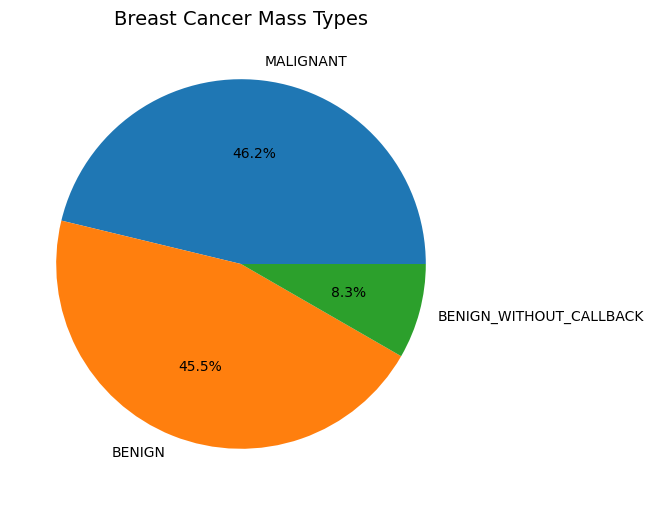

In [18]:
value = mass_data['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Mass Types', fontsize=14)
plt.show()

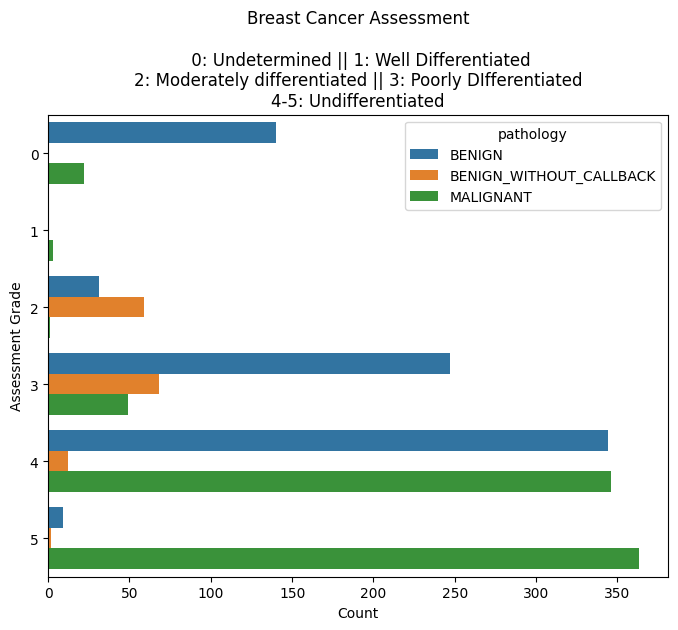

In [20]:
plt.figure(figsize=(8,6))
sns.countplot(mass_data, y='assessment', hue='pathology')
plt.title('Breast Cancer Assessment\n\n 0: Undetermined || 1: Well Differentiated\n2: Moderately differentiated || 3: Poorly DIfferentiated\n4-5: Undifferentiated',
          fontsize=12)
plt.ylabel('Assessment Grade')
plt.xlabel('Count')
plt.show()

In [21]:
images = dicom_info['SeriesDescription'].value_counts()
images = images.reset_index()
images = images.rename(columns={'index':'SeriesDescription','SeriesDescription':'counts'})

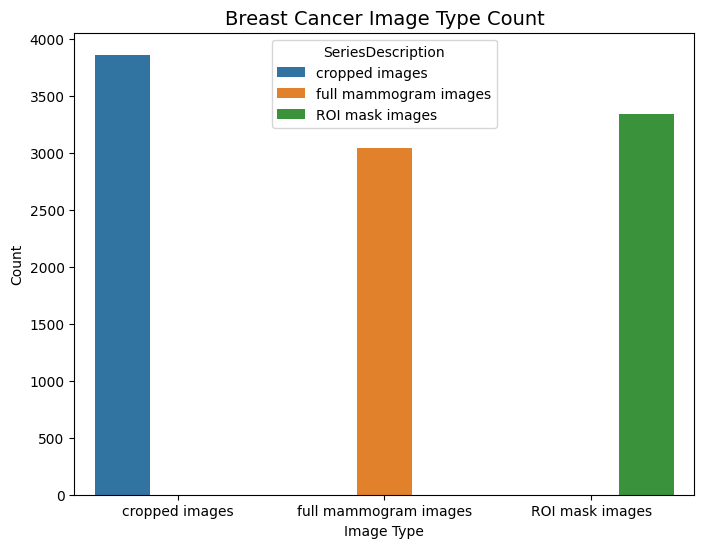

In [22]:
images = dicom_info['SeriesDescription'].value_counts()
plt.figure(figsize=(8,6))

sns.countplot(dicom_info, x='SeriesDescription', hue='SeriesDescription', orient='h')
plt.title('Breast Cancer Image Type Count', fontsize=14)
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.show()

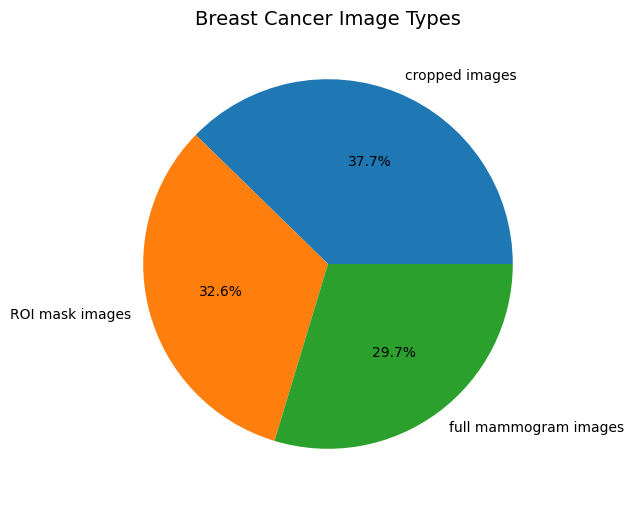

In [23]:
images = dicom_info['SeriesDescription'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(images, labels=images.index, autopct='%1.1f%%')
plt.title('Breast Cancer Image Types', fontsize=14)
plt.show()

#Image Enhancement

In [13]:
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [14]:
def image_processor(image_path, target_size):
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (target_size[1], target_size[0]))
    image_array = image / 255.0
    return image_array

In [15]:
# Define the target size
target_size = (224, 224, 3)

# Apply preprocessor to train data
mass_data['processed images'] = mass_data['image file path'].apply(lambda x: image_processor(x, target_size))

# Create a binary mapper
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

# Convert the processed_images column to an array
X_resized = np.array(mass_data['processed images'].tolist())

# Apply class mapper to pathology column
mass_data['labels'] = mass_data['pathology'].replace(class_mapper)

# Check the number of classes
num_classes = len(mass_data['labels'].unique())


#Preparing the Train/Test Set

In [16]:
# Split data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resized, mass_data['labels'].values, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Convert integer labels to one-hot encoded labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [17]:
print("X_train: ", X_train.shape)
print("y_train:", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (1187, 224, 224, 3)
y_train: (1187, 2)
X_test:  (341, 224, 224, 3)
y_test:  (341, 2)
X_val:  (168, 224, 224, 3)
y_val:  (168, 2)


In [19]:
# Convert one-hot encoded labels to single values for CNN Model
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

In [20]:
print("y_train:", y_train.shape)
print("y_test: ", y_test.shape)
print("y_val: ", y_val.shape)

y_train: (1187,)
y_test:  (341,)
y_val:  (168,)


#CNN Model

In [20]:
from keras.models import Sequential
from keras import layers, models
from keras.optimizers import RMSprop, Adam
from keras.layers import Flatten, Dense, Embedding

In [21]:
model0 = models.Sequential()

model0.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model0.add(layers.MaxPooling2D((2, 2)))
model0.add(layers.Conv2D(64, (3, 3), activation='relu'))
model0.add(layers.MaxPooling2D((2, 2)))
model0.add(layers.Conv2D(128, (3, 3), activation='relu'))
model0.add(layers.MaxPooling2D((2, 2)))

model0.add(layers.Flatten())
model0.add(layers.Dense(48, activation='relu'))
model0.add(layers.Dropout(0.5))
model0.add(layers.Dense(1, activation='sigmoid'))

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [22]:
model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history0 = model0.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

test_loss, test_acc = model0.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/50
38/38 [==============================] - 17s 88ms/step - loss: 0.6945 - accuracy: 0.5307 - val_loss: 0.6915 - val_accuracy: 0.5179
Epoch 2/50
38/38 [==============================] - 2s 55ms/step - loss: 0.6880 - accuracy: 0.5577 - val_loss: 0.6777 - val_accuracy: 0.6012
Epoch 3/50
38/38 [==============================] - 2s 56ms/step - loss: 0.6798 - accuracy: 0.5729 - val_loss: 0.6671 - val_accuracy: 0.5833
Epoch 4/50
38/38 [==============================] - 2s 50ms/step - loss: 0.6492 - accuracy: 0.6091 - val_loss: 0.6655 - val_accuracy: 0.5655
Epoch 5/50
38/38 [==============================] - 2s 50ms/step - loss: 0.6157 - accuracy: 0.6411 - val_loss: 0.6687 - val_accuracy: 0.5655
Epoch 6/50
38/38 [==============================] - 2s 49ms/step - loss: 0.5892 - accuracy: 0.6731 - val_loss: 0.6951 - val_accuracy: 0.5952
Epoch 7/50
38/38 [==============================] - 2s 50ms/step - loss: 0.5345 - accuracy: 0.7262 - val_loss: 0.7729 - val_accuracy: 0.5833
Epoch 8/50
3

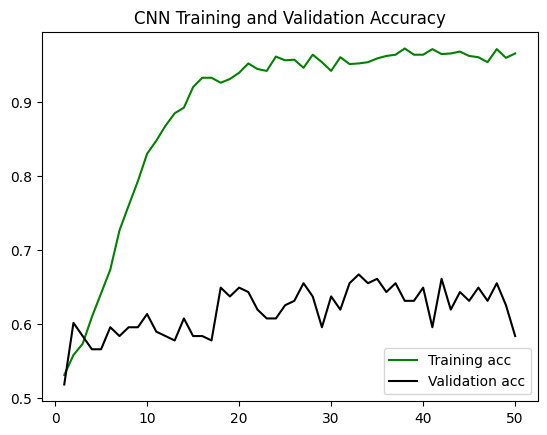

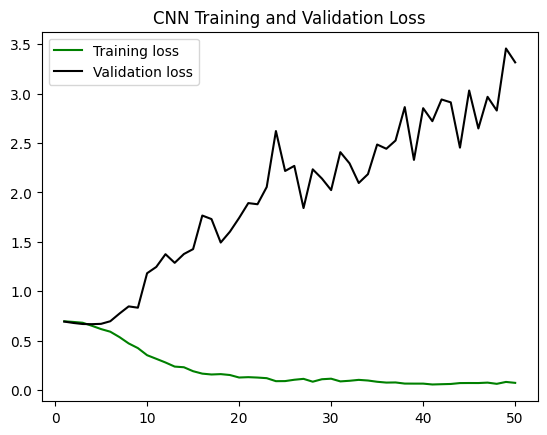

In [23]:
acc = history0.history['accuracy']
val_acc = history0.history['val_accuracy']
loss = history0.history['loss']
val_loss = history0.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'k', label='Validation acc')
plt.title('CNN Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'k', label='Validation loss')
plt.title('CNN Training and Validation Loss')
plt.legend()

plt.show()

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model0.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

report0 = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report0)

cm0 = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm0)

11/11 [==============================] - 0s 22ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       175
           1       0.00      0.00      0.00       166

    accuracy                           0.51       341
   macro avg       0.26      0.50      0.34       341
weighted avg       0.26      0.51      0.35       341

Confusion Matrix:
[[175   0]
 [166   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


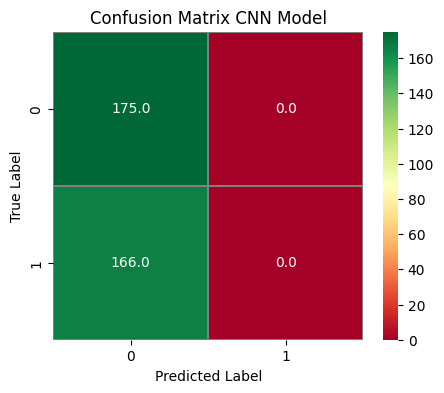

In [25]:
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm0, annot=True, linewidths=0.01,cmap="RdYlGn",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CNN Model")
plt.show()

CNN Second Iteration

In [21]:
model1 = models.Sequential()

model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Flatten())
model1.add(layers.Dense(48, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(64, activation='relu'))   # Additional layer
model1.add(layers.Dense(128, activation='relu'))  # Additional layer
model1.add(layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [22]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history1 = model1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

test_loss, test_acc = model1.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/100
38/38 [==============================] - 18s 96ms/step - loss: 0.6948 - accuracy: 0.5206 - val_loss: 0.6902 - val_accuracy: 0.5179
Epoch 2/100
38/38 [==============================] - 2s 52ms/step - loss: 0.6847 - accuracy: 0.5628 - val_loss: 0.6789 - val_accuracy: 0.5714
Epoch 3/100
38/38 [==============================] - 2s 52ms/step - loss: 0.6587 - accuracy: 0.6226 - val_loss: 0.6598 - val_accuracy: 0.5357
Epoch 4/100
38/38 [==============================] - 2s 52ms/step - loss: 0.6361 - accuracy: 0.6302 - val_loss: 0.6821 - val_accuracy: 0.5238
Epoch 5/100
38/38 [==============================] - 2s 51ms/step - loss: 0.5972 - accuracy: 0.6874 - val_loss: 0.6541 - val_accuracy: 0.6131
Epoch 6/100
38/38 [==============================] - 2s 52ms/step - loss: 0.5244 - accuracy: 0.7388 - val_loss: 0.7375 - val_accuracy: 0.5833
Epoch 7/100
38/38 [==============================] - 2s 58ms/step - loss: 0.4712 - accuracy: 0.7692 - val_loss: 0.8224 - val_accuracy: 0.5655
Epoch

#Resnet50

In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [19]:
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet50_model.layers:
    layer.trainable = False

model2 = models.Sequential()
model2.add(resnet50_model)
model2.add(layers.GlobalAveragePooling2D())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(2, activation='sigmoid'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [20]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

test_loss, test_acc = model2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/50
38/38 [==============================] - 23s 200ms/step - loss: 0.7146 - accuracy: 0.4928 - val_loss: 0.6948 - val_accuracy: 0.4821
Epoch 2/50
38/38 [==============================] - 4s 112ms/step - loss: 0.6953 - accuracy: 0.5274 - val_loss: 0.6930 - val_accuracy: 0.5179
Epoch 3/50
38/38 [==============================] - 4s 108ms/step - loss: 0.6914 - accuracy: 0.5535 - val_loss: 0.6928 - val_accuracy: 0.5179
Epoch 4/50
38/38 [==============================] - 4s 108ms/step - loss: 0.6922 - accuracy: 0.5375 - val_loss: 0.6925 - val_accuracy: 0.5179
Epoch 5/50
38/38 [==============================] - 4s 114ms/step - loss: 0.6906 - accuracy: 0.5366 - val_loss: 0.6933 - val_accuracy: 0.5179
Epoch 6/50
38/38 [==============================] - 4s 114ms/step - loss: 0.6910 - accuracy: 0.5484 - val_loss: 0.6957 - val_accuracy: 0.5179
Epoch 7/50
38/38 [==============================] - 4s 109ms/step - loss: 0.6931 - accuracy: 0.5299 - val_loss: 0.6925 - val_accuracy: 0.5179
Epoch

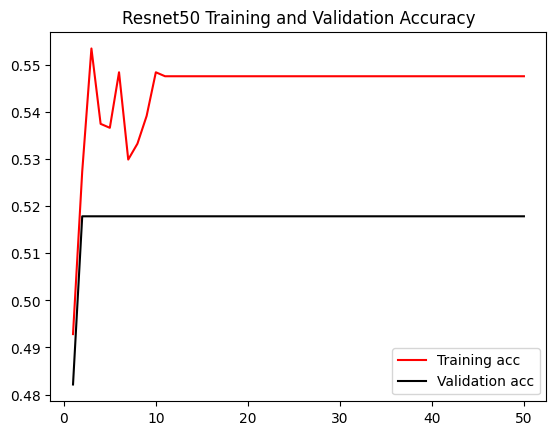

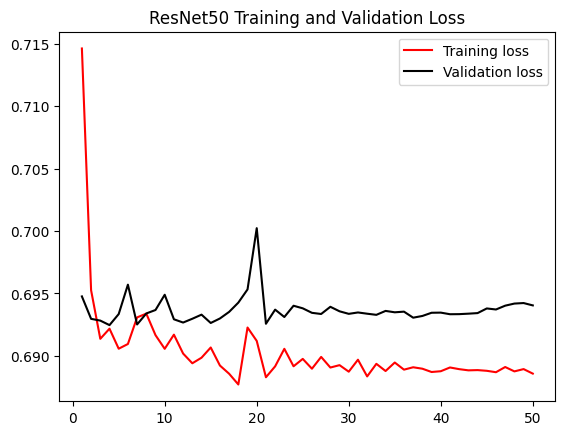

In [21]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'k', label='Validation acc')
plt.title('Resnet50 Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'k', label='Validation loss')
plt.title('ResNet50 Training and Validation Loss')
plt.legend()

plt.show()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report2 = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report2)

cm2 = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm2)

11/11 [==============================] - 3s 86ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       175
           1       0.00      0.00      0.00       166

    accuracy                           0.51       341
   macro avg       0.26      0.50      0.34       341
weighted avg       0.26      0.51      0.35       341

Confusion Matrix:
[[175   0]
 [166   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


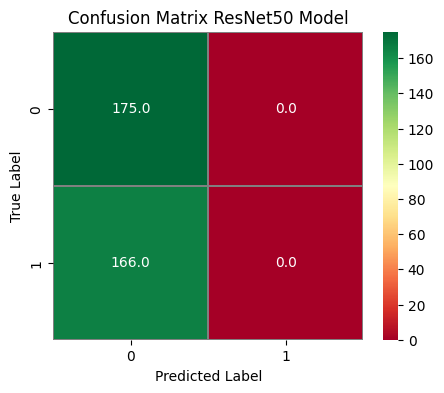

In [23]:
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm2, annot=True, linewidths=0.01,cmap="RdYlGn",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix ResNet50 Model")
plt.show()

ResNet50 Second Iteration

In [22]:
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet50_model.layers:
    layer.trainable = False

model3 = models.Sequential()
model3.add(resnet50_model)
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(16, activation='relu'))
model3.add(layers.Dense(1, activation='softmax'))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [23]:
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history3 = model3.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

test_loss, test_acc = model3.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/100
38/38 [==============================] - 25s 195ms/step - loss: 0.7434 - accuracy: 0.4558 - val_loss: 0.6930 - val_accuracy: 0.5060
Epoch 2/100
38/38 [==============================] - 4s 108ms/step - loss: 0.7006 - accuracy: 0.4676 - val_loss: 0.6924 - val_accuracy: 0.5179
Epoch 3/100
38/38 [==============================] - 4s 113ms/step - loss: 0.6930 - accuracy: 0.5156 - val_loss: 0.6929 - val_accuracy: 0.5179
Epoch 4/100
38/38 [==============================] - 4s 113ms/step - loss: 0.6928 - accuracy: 0.5021 - val_loss: 0.6936 - val_accuracy: 0.5179
Epoch 5/100
38/38 [==============================] - 4s 114ms/step - loss: 0.6896 - accuracy: 0.5333 - val_loss: 0.6931 - val_accuracy: 0.5179
Epoch 6/100
38/38 [==============================] - 4s 113ms/step - loss: 0.6888 - accuracy: 0.5375 - val_loss: 0.6928 - val_accuracy: 0.5179
Epoch 7/100
38/38 [==============================] - 5s 123ms/step - loss: 0.6898 - accuracy: 0.5510 - val_loss: 0.6931 - val_accuracy: 0.517

#CNN Model VGG16

In [18]:
from keras.applications import vgg16

In [20]:
vgg16_model = tf.keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3)
)

for layer in vgg16_model.layers:
    layer.trainable = False

model4 = tf.keras.Sequential()
model4.add(vgg16_model)
model4.add(tf.keras.layers.GlobalAveragePooling2D())
model4.add(tf.keras.layers.Dropout(0.5))
model4.add(tf.keras.layers.Dense(256, activation = 'relu'))
model4.add(tf.keras.layers.Dense(128, activation = 'relu'))
model4.add(tf.keras.layers.Dense(64, activation = 'relu'))
model4.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                      

In [21]:
model4.compile(optimizer = 'adam', loss='binary_crossentropy',metrics=['accuracy'])

history4 = model4.fit(X_train, y_train, epochs = 50, batch_size = 32,  validation_data=(X_val, y_val))

test_loss, test_acc = model4.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/50
38/38 [==============================] - 22s 206ms/step - loss: 0.6986 - accuracy: 0.5215 - val_loss: 0.6908 - val_accuracy: 0.5060
Epoch 2/50
38/38 [==============================] - 5s 143ms/step - loss: 0.6971 - accuracy: 0.5249 - val_loss: 0.6835 - val_accuracy: 0.5238
Epoch 3/50
38/38 [==============================] - 5s 138ms/step - loss: 0.6908 - accuracy: 0.5425 - val_loss: 0.6858 - val_accuracy: 0.5238
Epoch 4/50
38/38 [==============================] - 6s 156ms/step - loss: 0.6851 - accuracy: 0.5628 - val_loss: 0.6786 - val_accuracy: 0.5179
Epoch 5/50
38/38 [==============================] - 6s 159ms/step - loss: 0.6832 - accuracy: 0.5619 - val_loss: 0.6780 - val_accuracy: 0.6071
Epoch 6/50
38/38 [==============================] - 6s 157ms/step - loss: 0.6821 - accuracy: 0.5678 - val_loss: 0.6766 - val_accuracy: 0.6012
Epoch 7/50
38/38 [==============================] - 6s 160ms/step - loss: 0.6844 - accuracy: 0.5484 - val_loss: 0.6713 - val_accuracy: 0.6250
Epoch

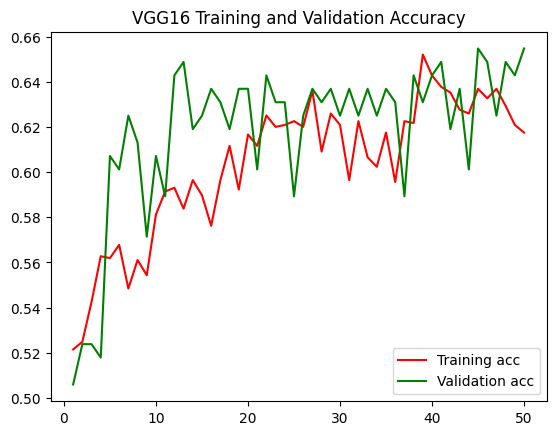

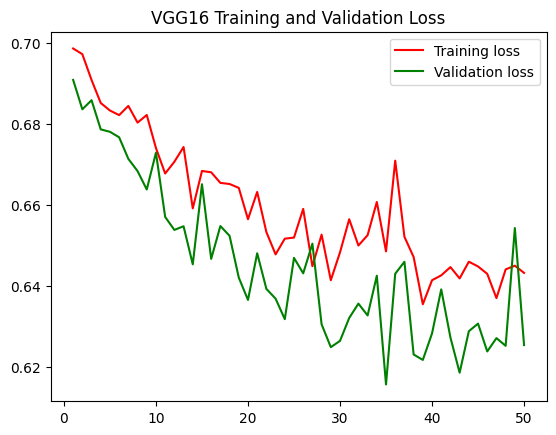

In [22]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('VGG16 Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('VGG16 Training and Validation Loss')
plt.legend()

plt.show()

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model4.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report4 = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report4)

cm4 = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm4)

11/11 [==============================] - 2s 133ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.53      0.62       175
           1       0.62      0.80      0.69       166

    accuracy                           0.66       341
   macro avg       0.67      0.66      0.66       341
weighted avg       0.68      0.66      0.65       341

Confusion Matrix:
[[ 93  82]
 [ 34 132]]


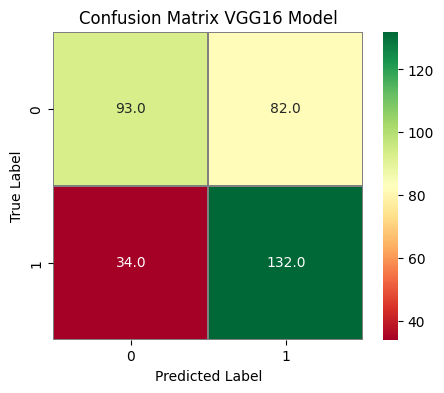

In [24]:
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm4, annot=True, linewidths=0.01,cmap="RdYlGn",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix VGG16 Model")
plt.show()

Second Iteration of VGG16 Model

In [19]:
vgg16_model = tf.keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3)
)

for layer in vgg16_model.layers:
    layer.trainable = False

model5 = tf.keras.Sequential()
model5.add(vgg16_model)
model5.add(tf.keras.layers.GlobalAveragePooling2D())
model5.add(tf.keras.layers.Dropout(0.5))
model5.add(tf.keras.layers.Dense(256, activation = 'relu'))
model5.add(tf.keras.layers.Dense(128, activation='relu'))
model5.add(tf.keras.layers.Dense(64, activation='relu'))
model5.add(tf.keras.layers.Dense(32, activation='relu'))
model5.add(tf.keras.layers.Dense(16, activation='relu'))
model5.add(tf.keras.layers.Dense(2, activation = 'sigmoid'))

model5.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                82

In [20]:
model5.compile(optimizer = 'rmsprop', loss='binary_crossentropy',metrics=['accuracy'])

history5 = model5.fit(X_train, y_train, epochs = 50, batch_size = 32,  validation_data=(X_val, y_val))

test_loss, test_acc = model5.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/50
38/38 [==============================] - 23s 207ms/step - loss: 0.6943 - accuracy: 0.5451 - val_loss: 0.6928 - val_accuracy: 0.5179
Epoch 2/50
38/38 [==============================] - 6s 154ms/step - loss: 0.6920 - accuracy: 0.5459 - val_loss: 0.6946 - val_accuracy: 0.5179
Epoch 3/50
38/38 [==============================] - 6s 159ms/step - loss: 0.6928 - accuracy: 0.5392 - val_loss: 0.6926 - val_accuracy: 0.5179
Epoch 4/50
38/38 [==============================] - 6s 154ms/step - loss: 0.6901 - accuracy: 0.5476 - val_loss: 0.6922 - val_accuracy: 0.5179
Epoch 5/50
38/38 [==============================] - 6s 156ms/step - loss: 0.6910 - accuracy: 0.5409 - val_loss: 0.6921 - val_accuracy: 0.5179
Epoch 6/50
38/38 [==============================] - 6s 160ms/step - loss: 0.6895 - accuracy: 0.5476 - val_loss: 0.6930 - val_accuracy: 0.5179
Epoch 7/50
38/38 [==============================] - 5s 141ms/step - loss: 0.6890 - accuracy: 0.5484 - val_loss: 0.6921 - val_accuracy: 0.5179
Epoch

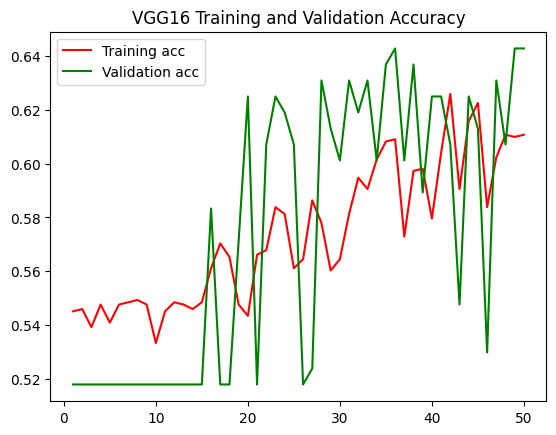

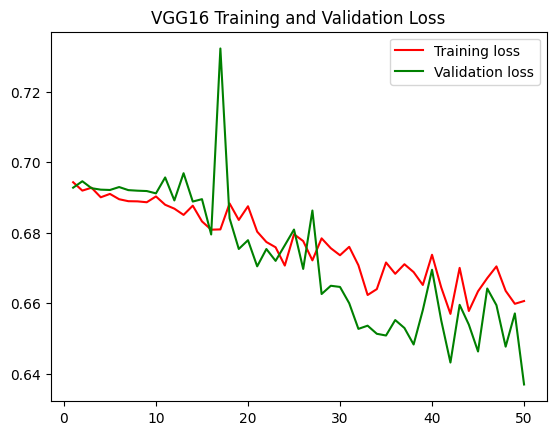

In [21]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('VGG16 Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('VGG16 Training and Validation Loss')
plt.legend()

plt.show()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model5.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report5 = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report5)

cm5 = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm5)

11/11 [==============================] - 2s 116ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       175
           1       0.66      0.64      0.65       166

    accuracy                           0.67       341
   macro avg       0.67      0.66      0.67       341
weighted avg       0.67      0.67      0.67       341

Confusion Matrix:
[[121  54]
 [ 60 106]]


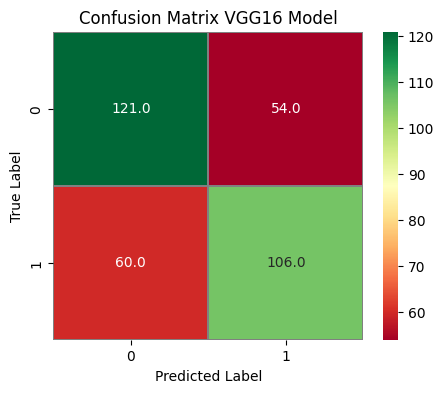

In [23]:
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm5, annot=True, linewidths=0.01,cmap="RdYlGn",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix VGG16 Model")
plt.show()